# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
import glob
import os
import math
import shutil

import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from functools import partial

%matplotlib inline

## Cleanup

In [2]:
output_videos_dir = os.path.abspath('output_videos')

# remove folder with rendered video
if os.path.exists(output_videos_dir):
    print("Removing: ", output_videos_dir)
    shutil.rmtree(output_videos_dir)
else:
    print("Not exists: ", output_videos_dir)

Not exists:  /Users/volkodav/self_driving_car_proj/proj/CarND-LaneLines-P1/output_videos


## Show Original Images

In [3]:
def plot_images(images, cols=2, figsize=(8, 11)):
    rows = (len(images) / cols) + 1

    plt.figure(figsize=figsize)
    for idx, image in enumerate(images):
        plt.subplot(rows, cols, idx + 1)
        if len(image.shape) == 2:
            plt.imshow(image, cmap="gray")
        else:
            plt.imshow(image)
        plt.xticks()
        plt.yticks()
    plt.tight_layout()
    plt.show()

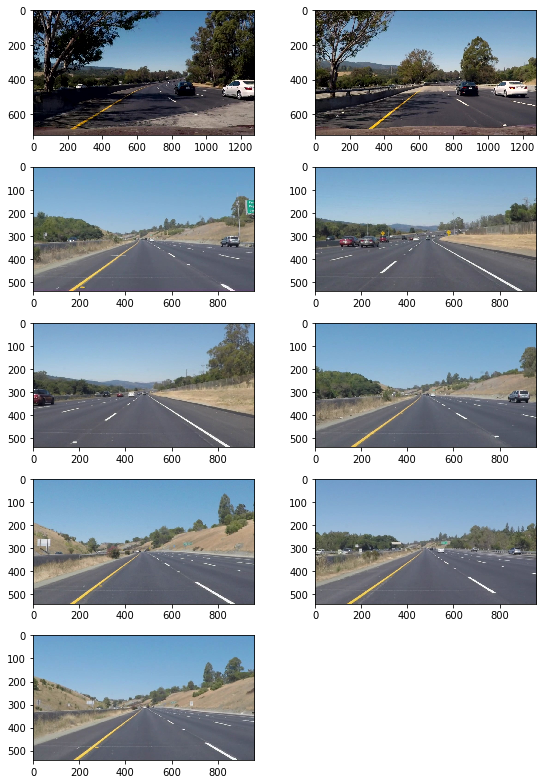

In [4]:
orig_images = [plt.imread(path) for path in glob.glob('test_images/*.jpg')]
plot_images(orig_images)

## Helper Functions

In [5]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


# Python 3 has support for cool math symbols.
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)


def draw_lanes(img, lane_lines, color=[255, 0, 0], thickness=10, alpha=0.8, beta=1.0, gamma=0.0):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    lane_line_image = np.zeros_like(img)
    for lane_line in lane_lines:
        if lane_line is not None:
            cv2.line(lane_line_image, *lane_line, color, thickness)
    return weighted_img(lane_line_image, img, alpha, beta, gamma)


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    return cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)

## Define application parameters

In [6]:
# Color Selection mask parameters
color_mask = np.array([220, 150, 0])

# ROI polygon coefficients
top_left_x = 0.4
top_left_y = 0.6
bottom_left_x = 0.1
bottom_left_y = 1.0
top_right_x = 0.6
top_right_y = 0.6
bottom_right_x = 0.95
bottom_right_y = 1.0

# Canny Edge Detection parameters
kernel_size = 15
low_threshold = 50
high_threshold = 150

# Hough Transform parameters to find a lane lines
rho = 2
theta = np.pi / 180
threshold = 20
min_line_len = 7
max_line_gap = 200

# Extrapolation parameter
ysize_extr = 0.6

## Build a Lane Finding Pipeline



In [7]:
def filter_color(image, color_mask=color_mask):
    mask = cv2.inRange(image, color_mask, np.array([255, 255, 255]))
    return cv2.bitwise_and(image, image, mask=mask)


def calc_line_points(y1, y2, lane_line):
    if lane_line is None:
        return None

    slope, intercept = lane_line
    x1 = int((y1 - intercept) / slope)
    x2 = int((y2 - intercept) / slope)

    return ((x1, int(y1)), (x2, int(y2)))


def calc_average_lines(image, lines):
    left_lines = []
    right_lines = []
    left_weights = []
    right_weights = []

    for line in lines:
        for x1, y1, x2, y2 in line:
            if x2 == x1:
                # vertical line
                continue
            slope, intercept = np.polyfit((x1, x2), (y1, y2), 1)
            length = np.sqrt((y2 - y1) ** 2 + (x2 - x1) ** 2)
            if slope > 0:
                right_lines.append((slope, intercept))
                right_weights.append((length))
            else:
                left_lines.append((slope, intercept))
                left_weights.append((length))

    left_lane = None
    right_lane = None

    # longer lines - more weights (see: weighted arithmetic mean)
    if len(left_weights) > 0:
        left_lane = np.dot(left_weights, left_lines) / np.sum(left_weights)

    if len(right_weights) > 0:
        right_lane = np.dot(right_weights, right_lines) / np.sum(right_weights)

    # bottom of the image
    y1 = image.shape[0]
    # extrapolate a line
    y2 = y1 * ysize_extr

    return (calc_line_points(y1, y2, left_lane),
            calc_line_points(y1, y2, right_lane))


def get_vertices(image):
    img_shape = image.shape
    ysize = img_shape[0]
    xsize = img_shape[1]
    top_left = [xsize * top_left_x, ysize * top_left_y]
    bottom_left = [xsize * bottom_left_x, ysize * bottom_left_y]
    top_right = [xsize * top_right_x, ysize * top_right_y]
    bottom_right = [xsize * bottom_right_x, ysize * bottom_right_y]
    return np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)

## Test on Images



### Filtered Images

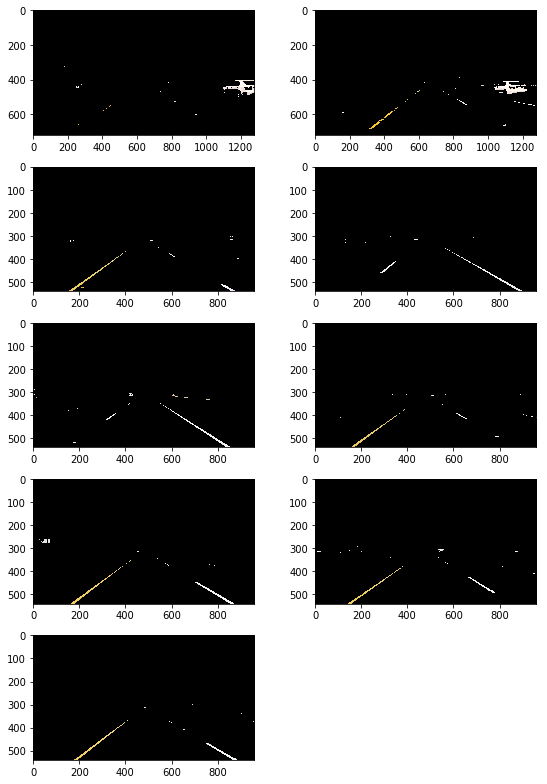

In [8]:
filtered_images = list(map(filter_color, orig_images))
plot_images(filtered_images)

### Grayscale Images

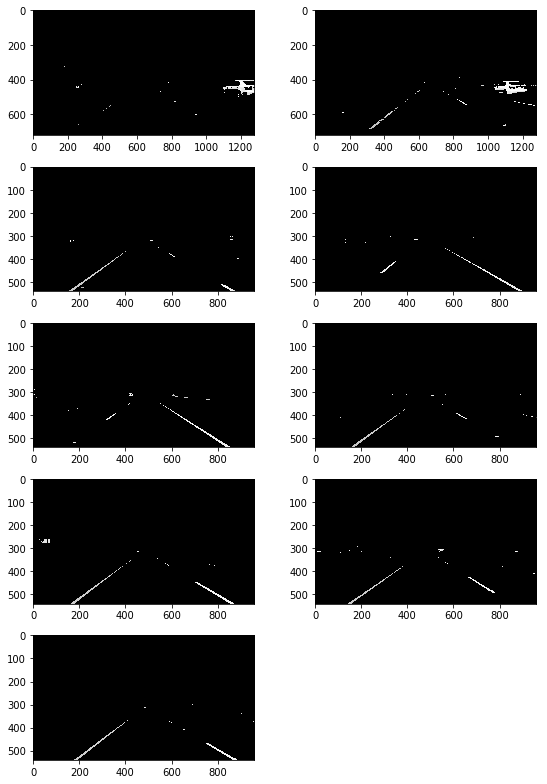

In [9]:
grayscale_images = list(map(grayscale, filtered_images))
plot_images(grayscale_images)

### Smooth Gray Images

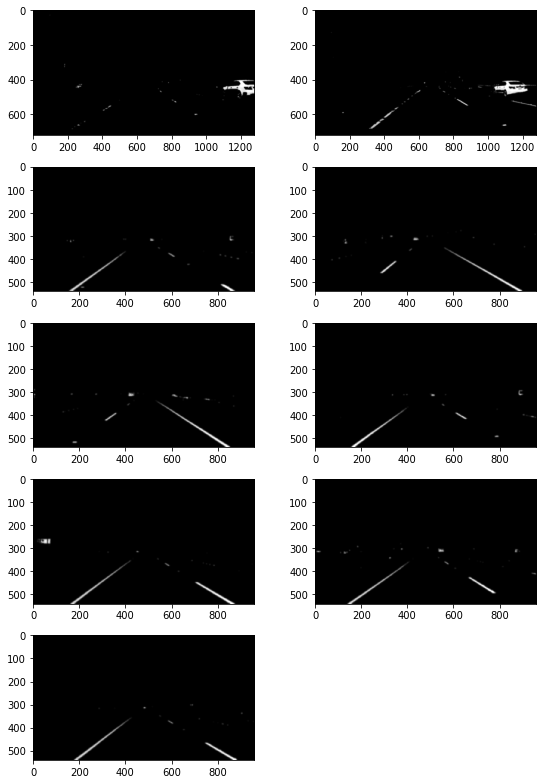

In [10]:
gaussian_blur_images = list(map(partial(gaussian_blur, kernel_size=kernel_size), grayscale_images))
plot_images(gaussian_blur_images)

### Detected Edges

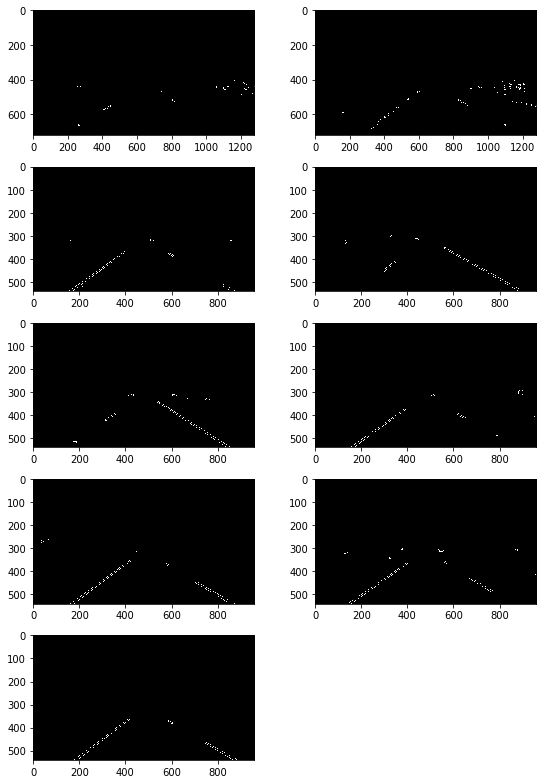

In [11]:
canny_images = list(map(partial(canny, low_threshold=low_threshold, high_threshold=high_threshold), gaussian_blur_images))
plot_images(canny_images)

### Detected Edges within ROI

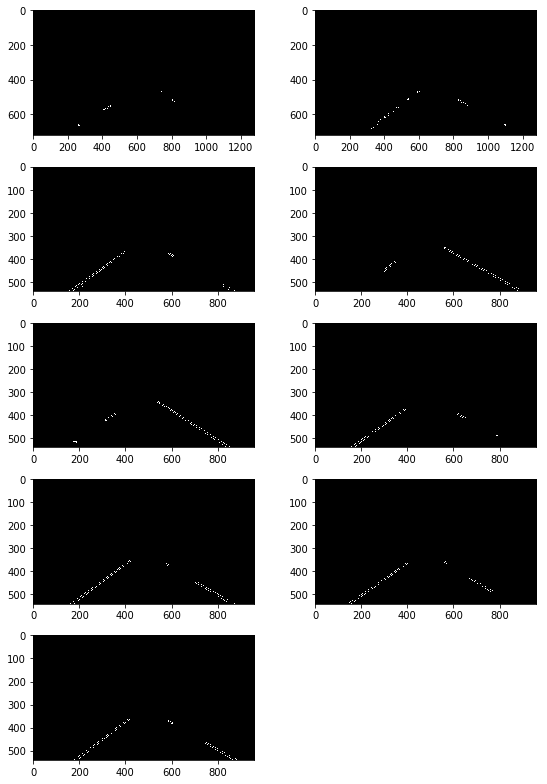

In [12]:
roi_images = []
for img in canny_images:
    roi_images.append(region_of_interest(img, get_vertices(img)))
plot_images(roi_images)

### Lane Lines

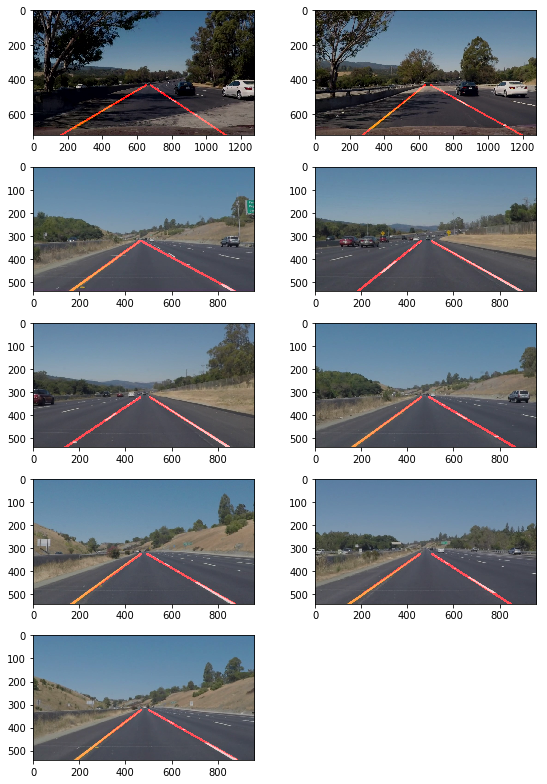

In [13]:
lane_lines_images = []
for idx, img in enumerate(roi_images):
    lines = hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap)
    left_line, right_line = calc_average_lines(img, lines)
    # draw lane lines on original image
    lane_lines_images.append(draw_lanes(orig_images[idx], (left_line, right_line)))
plot_images(lane_lines_images)

## Test on Videos

In [14]:
def process_image(image):
    filtered_image = filter_color(image)
    gray = grayscale(filtered_image)
    smooth_gray = gaussian_blur(gray, kernel_size)
    edges = canny(smooth_gray, low_threshold, high_threshold)
    selected_roi = region_of_interest(edges, get_vertices(image))
    lines = hough_lines(selected_roi, rho, theta, threshold, min_line_len, max_line_gap)
    left_line, right_line = calc_average_lines(image, lines)
    
    return draw_lanes(image, (left_line, right_line))


def process_video(video_input, output_dir_name=output_videos_dir):
    if not os.path.exists(output_dir_name):
        os.makedirs(output_dir_name, exist_ok=True)

    video_input_fname = os.path.basename(video_input)
    video_output_path = os.path.join(output_videos_dir, video_input_fname)

    clip = VideoFileClip(video_input)
    processed = clip.fl_image(process_image)
    processed.write_videofile(video_output_path, audio=False)

    return video_output_path

In [15]:
for video_input in glob.glob('test_videos/*.mp4'):
    %time process_video(video_input)

[MoviePy] >>>> Building video /Users/volkodav/self_driving_car_proj/proj/CarND-LaneLines-P1/output_videos/challenge.mp4
[MoviePy] Writing video /Users/volkodav/self_driving_car_proj/proj/CarND-LaneLines-P1/output_videos/challenge.mp4


100%|██████████| 251/251 [00:07<00:00, 32.83it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /Users/volkodav/self_driving_car_proj/proj/CarND-LaneLines-P1/output_videos/challenge.mp4 

CPU times: user 6.28 s, sys: 2.04 s, total: 8.32 s
Wall time: 8.56 s
[MoviePy] >>>> Building video /Users/volkodav/self_driving_car_proj/proj/CarND-LaneLines-P1/output_videos/solidWhiteRight.mp4
[MoviePy] Writing video /Users/volkodav/self_driving_car_proj/proj/CarND-LaneLines-P1/output_videos/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:03<00:00, 65.93it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /Users/volkodav/self_driving_car_proj/proj/CarND-LaneLines-P1/output_videos/solidWhiteRight.mp4 

CPU times: user 2.98 s, sys: 1.09 s, total: 4.08 s
Wall time: 3.91 s
[MoviePy] >>>> Building video /Users/volkodav/self_driving_car_proj/proj/CarND-LaneLines-P1/output_videos/solidYellowLeft.mp4
[MoviePy] Writing video /Users/volkodav/self_driving_car_proj/proj/CarND-LaneLines-P1/output_videos/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:10<00:00, 65.23it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /Users/volkodav/self_driving_car_proj/proj/CarND-LaneLines-P1/output_videos/solidYellowLeft.mp4 

CPU times: user 9.4 s, sys: 3.17 s, total: 12.6 s
Wall time: 11 s


### solidWhiteRight.mp4

In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{}">
</video>
""".format("output_videos/solidWhiteRight.mp4"))

### solidYellowLeft.mp4

In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{}">
</video>
""".format("output_videos/solidYellowLeft.mp4"))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

### challenge.mp4

In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{}">
</video>
""".format("output_videos/challenge.mp4"))